In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = "32"
from IPython.display import clear_output

# this code simulations the 3srw with trapping

In [3]:
def walkit(k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-2,tmax=10,theta1=0.5,theta2=0.5,retT=False,T='geom'):
    """
    kap is the trapping rate from rest
    k1 is the inverse mean resting time
    k2 is the inverse mean moving time
    v is the velocity
    dt is the sampling interval
    tmax is the maximum time to walk
    theta1 is the probability of starting at rest
    theta2 is the probability of starting in motion
    retT is True or False and tells the function whether to return the set of sampling times
    T is the set of sampling times. if 'geom',
    they are generated as geometrically spaced with 10 per order of magnitude
    if 'lin', they are generated with interval dt. 
    They can also be input as whatever else. 
    """
    # check if the initial conditions are appropriate
    if theta1+theta2!=1.0:
        raise Exception('Initial conditions do not sum to 1.0!')
    # selection the initial condition
    s = int(np.random.random() > theta1) + 1 # initial state
    
    # process the set of sampling times
    if T=='geom':
        nperorder = 10
        T = np.geomspace(dt,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times
    elif T=='dt':
        T = np.arange(0,tmax+dt,dt)
    else:
        raise Exception('Problem with the input T! not equal to geom or dt')
        
    # initialize the simulation
    X = np.empty_like(T) # set of recorded displacements
    t = 0.0 # initial time
    x = 0.0 # initial position
    ns = 0 # saving index
    ts = T[ns] # next saving time
    nr = 0 # random number index
    nrbatch = 5000 # number of random values to generate at once
    R = np.random.random(size=(nrbatch,2)) # generate the first set of random values
    # start the simulation
    while t<tmax-dt:
        t += dt # update the time 
        r1,r2 = R[nr] # get a pair of randoms
        nr+=1  #update the index into the array of random values
        if s==1: # if walker is in a rest state
            val1 = 1 - np.exp(-k1*dt) > r1 # probability that transition to motion occurs
            val2 = 1 - np.exp(-kap*dt) > r2  # probability that trapping occurs 
            if val1 and not val2: # provided walker does not trap and does transition to motion
                s = 2  # move it to the motion state
            elif val2: # otherwise if walker traps,
                s=0 # move it to the trapped state
                X[ns:]=x # make all future elements of X have position x
                break # stop the simulation
        elif s==2: # if walker is in a motion state
            x = x + v*dt # walker moves a distance v*dt
            if np.exp(-k2*dt)<r1: # if walker transitions to a rest state
                s = 1   # assign it to rest 
        ### save the state of the walk 
        if t>=ts: # if t surpassed the save time
            X[ns] = x # save the value of x 
            ns+=1 # increment the saving index
            ts=T[ns] # find the next time saving happens       
        ### generate more random values when necessary 
        if nr==nrbatch-1: # if you're at the end of the list of randoms
            nr = 0  # reset the index into that list 
            R = np.random.random(size=(nrbatch,2)) # and regenerate the list
    return X # once the simulation is completed, return the set of positions 

def ens(Nens = 100, k1=1.0,k2=1.0,kap=1.0,v=1.0,dt=1e-5,tmax=100,theta1=0.5,theta2=0.5,T='geom'):
    """ do an ensemble of Nens (number) simulations 
    rows (first index) of X are individual simulations
    use geometrically spaced sampling intervals"""
    T0 = np.copy(T)
    # generate the set of sampling times
    if T=='geom':
        nperorder = 10
        T = np.geomspace(dt,tmax,nperorder*int(np.ceil(np.log10(tmax/tmin)))) # set of recording times
    elif T=='dt':
        T = np.arange(0,tmax+dt,dt)            
    # simulate the ensemble of walkers
    X = np.empty((Nens,T.size))
    for n in range(Nens):
        x = walkit(k1=k1,k2=k2,kap=kap,v=v,dt=dt,tmax=tmax,theta1=theta1,theta2=theta2,T=T0)
        X[n,:]=x
        clear_output(wait=True)
        print('sample {} of {}'.format(int(n+1),int(Nens)))
    # return the output
    return T,X

def cumulants(t,flag,k1,k2,kap,v,theta2):
    """ this provides the cumulants from any initial conditions """
    kp = k1 + k2
    the2 = theta2
    exp=np.exp
    sqrt = np.sqrt
    a = (kap+kp)/2.0
    b = sqrt(a**2-kap*k2)
    A1 = v/(2*b)*(the2+(the2*kap+k1)/(b-a))
    B1 = -v/(2*b)*(the2-(the2*kap+k1)/(a+b))
    C1 = -v/(2*b)*(1/(b-a)+1/(a+b))*(the2*kap+k1)
    def A2(t):
        out = (b*t-1)*(k1 + the2*(2*kap+k1+b-a))+the2*b
        out += (kap+k1)*(the2*kap+k1)/(b-a)**2*((b*t-1)*(b-a)-b) 
        out *= v**2/(2*b**3)
        return out
    def B2(t):
        out = (b*t+1)*(k1+the2*(2*kap+k1-a-b))+the2*b
        out += -(kap+k1)*(the2*kap+k1)/(a+b)**2*((b*t+1)*(a+b)+b) # EARLIER SIGN ERROR HERE
        # FIXED NOW
        out *= v**2/(2*b**3)
        return out
    C2 = v**2/(2*b**3)*(kap+k1)*(the2*kap+k1)*((2*b-a)/(b-a)**2+(a+2*b)/(a+b)**2)
    if flag==1: # compute the mean
        return A1*exp((b-a)*t)+B1*exp(-(a+b)*t)+C1
    elif flag==2: # compute the var
        out = (A2(t)-2*A1*C1-A1**2*exp((b-a)*t))*exp((b-a)*t)
        out += (B2(t)-2*B1*C1-B1**2*exp(-(a+b)*t))*exp(-(a+b)*t)
        out += C2 - C1**2 - 2*A1*B1*exp(-2*a*t)
        return out    

In [359]:
tmotion = 10.0
trest = 100.0
ttrap = 1000.0

k2 = 1/tmotion
k1 = 1/trest
kap = 1/ttrap
v = 0.5
theta1 = 0.6
theta2 = 0.4

T,X = ens(300,dt=1e-3,tmax=1e6,k1=k1,k2=k2,kap=kap,theta1=theta1,theta2=theta2,v=v)

KeyboardInterrupt: 

(0.001, 10000000.0)

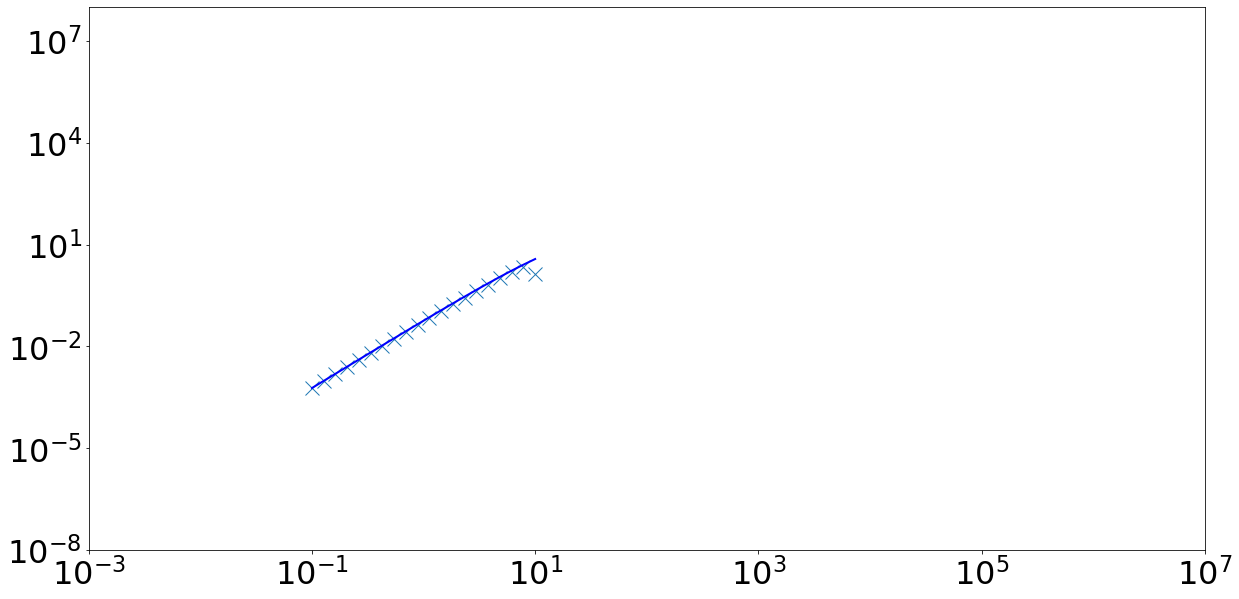

In [347]:
t = np.geomspace(1e-3,1e7,100)
plt.loglog(T,X.var(0),'x',markersize=14,color='blue')
plt.loglog(T,cumulants(T,2,k1,k2,kap,v,theta2),color='black',lw=2)#,marker='x',linestyle='None')
plt.ylim(1e-8,1e8)
plt.xlim(1e-3,1e7)

In [ ]:
tm = 1
tr = 10
tt = 100000
k1 = 1/tr
k2 = 1/tm
kap = 1/tt
v=0.1


# k1/(k1+k2) is fraction of time spent in motion
# k2/(k1+k2) is fraction of time spent at rest

# crossover from 1st ballistic regime
time1 = 1/np.sqrt(k1*k2)
plt.axvline(time1,color='black')

# crossover zone from 2nd ballistic regime
tau1 = 1/kap
tau2 = 1/(k1*kap/(k1+k2))
time3 = np.sqrt(tau1*tau2)
plt.axvline(time3,color='black')
plt.xlabel(r'$t$',fontsize=12)
plt.ylabel(r'$\sigma_x^2(t)$',rotation=0,fontsize=12)

# crossover zone into 2nd ballistic regime
#plt.axvline(np.sqrt(1/kap/k2))
#plt.axvline(np.sqrt(1/kap*1/(k1*kap/(k1+k2))))

# mix the lower two times... 
time2 = (1/k1*tau2)**(1/2)
plt.axvline(time2,color='black')

fig = plt.gcf()
fig.set_figheight(7/1.6)
fig.set_figwidth(7)
fig.savefig('../grl/figures/diffusion.png', bbox_inches='tight',dpi=600)

In [ ]:
# code scrap to draw the three ranges onto a plot 
val = 1e-2
# local range
t0 = np.geomspace(1e-2,time1,100)
plt.loglog(t0,t0**3*val,linestyle='-.',color='black')
val = (t0**3*val).max()
# intermediate range
t1 = np.geomspace(time1,time2,100)
plt.loglog(t1,t1/t1.min()*val,linestyle='-.',color='black')
val = (t1/t1.min()*val).max()
# global range
t2 = np.geomspace(time2,time3,100)
plt.loglog(t2,t2**3/(t2**3).min()*val,linestyle='-.',color='black')
# geomorphic range

# scraps 
plt.loglog(T,X.var(0),'o',color='red',markersize=10,mfc='none')
plt.loglog(T,cumulants(T,2,k1,k2,kap,v,theta2=0.7),color='black',lw=3)
plt.ylim(1e-4,1e4)
plt.xlim(1e-2,1e7)

# learn to simulate the joint pdf of x and t 

In [ ]:
k2 = 1.0
k1 = 0.1
kap = 0.01
v = 2.0
theta1 = 0.0
theta2 = 1.0
T,X = ens(12000,dt=1e-2,tmax=200,k1=k1,k2=k2,kap=kap,theta1=theta1,theta2=theta2,v=v,T='dt')

sample 10933 of 12000


In [26]:
# define bins over x axis
dl = 1.0
xbins = np.arange(0,np.nanmax(X)+dl,dl)
# define bins over t axis
dtau = 1.0
tbins = np.arange(0,T.max()+dtau,dtau)
Xs = X.flatten()
Ts = np.hstack((T,)*X.shape[0])
hist,_,_ = np.histogram2d(Xs,Ts,bins=[xbins,tbins])

(0, 40)

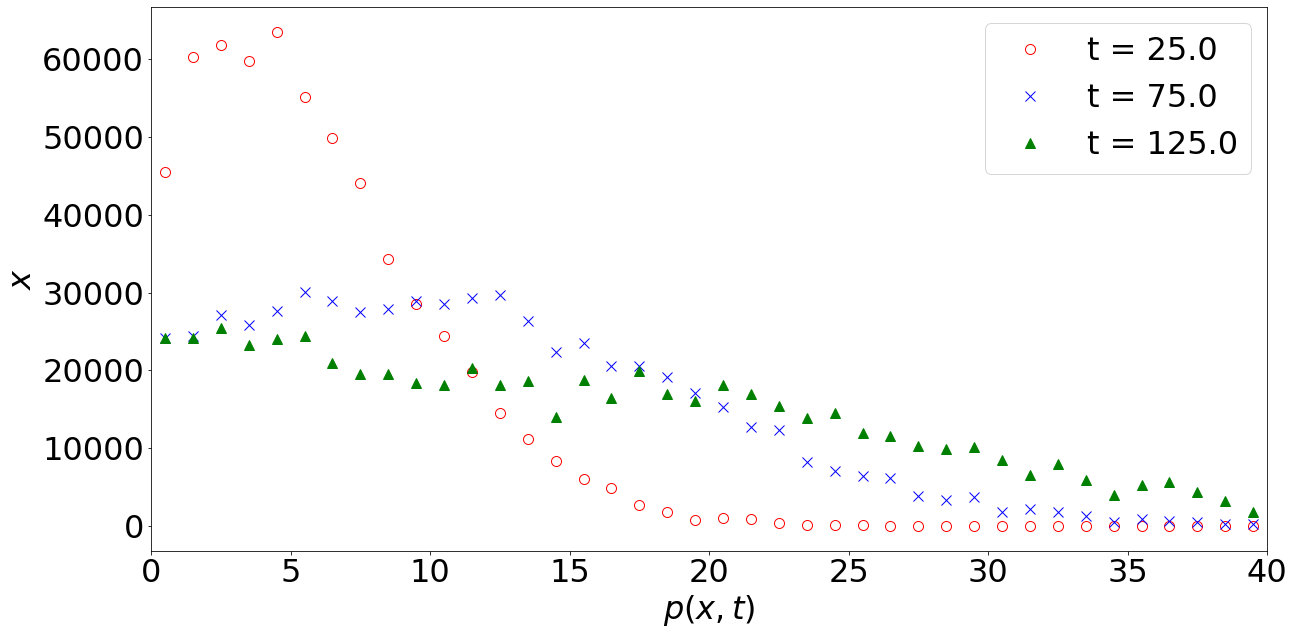

In [29]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

x = (xbins[:-1]+xbins[1:])/2.0
t1 = 25.0
i1 = find_nearest(tbins,t1)
plt.plot(x,hist[:,i1],'o',color='red',label='t = {}'.format(round(tbins[i1],2)),markersize=10,mfc='none')
t2 = 75.0
i2 = find_nearest(tbins,t2)
plt.plot(x,hist[:,i2],'x',color='blue',label='t = {}'.format(round(tbins[i2],2)),markersize=10)
t3 = 125.0
i3 = find_nearest(tbins,t3)
plt.plot(x,hist[:,i3],'^',color='green',label='t = {}'.format(round(tbins[i3],2)),markersize=10)
plt.legend()
plt.xlabel(r'$p(x,t)$')
plt.ylabel(r'$x$')

plt.xlim(0,40)